In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\MEHEDI~1\AppData\Local\Temp/ipykernel_4640/1754229008.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


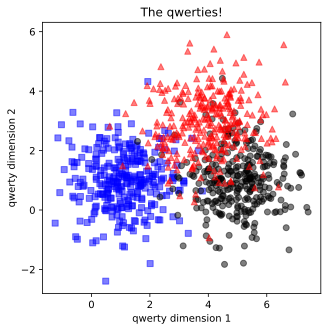

In [2]:
nPerClust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [4,3]

a = [ A[0]+np.random.randn(nPerClust)*blur,A[1]+np.random.randn(nPerClust)*blur]
b = [ B[0]+np.random.randn(nPerClust)*blur,B[1]+np.random.randn(nPerClust)*blur]
c = [ C[0]+np.random.randn(nPerClust)*blur,C[1]+np.random.randn(nPerClust)*blur]

data_np = np.hstack((a,b,c)).T
labels_np = np.hstack((np.zeros((nPerClust)),
                     np.ones((nPerClust)),
                     1+np.ones((nPerClust))))

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.2)

train_dataset = TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data,test_labels)

batchsize = 16
train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])


In [4]:
def createTheQwertyNet(initialLR):
    
    class qwertyNet(nn.Module):
        
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(2,8)
            self.fc1 = nn.Linear(8,8)
            self.output = nn.Linear(8,3)
            
        def forward(self,x):
            
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
        
    net = qwertyNet()
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=initialLR)
    stepsize = batchsize*len(train_loader)
    schedular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=stepsize,gamma=.5)
    
    return net,lossfun,optimizer,schedular
            
        
                
                

In [5]:
len(train_loader)*batchsize

720

In [6]:
net = createTheQwertyNet(.01)[0]
optimizer = torch.optim.SGD(net.parameters(),lr=.01)
stepsize = batchsize*len(train_loader)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=stepsize,gamma=.5)

In [7]:
for epochi in range(3):
    for batchnum in range(10):
        print(f'Batch{batchnum},epoch{epochi}:LR={scheduler.get_last_lr()[0]}')

Batch0,epoch0:LR=0.01
Batch1,epoch0:LR=0.01
Batch2,epoch0:LR=0.01
Batch3,epoch0:LR=0.01
Batch4,epoch0:LR=0.01
Batch5,epoch0:LR=0.01
Batch6,epoch0:LR=0.01
Batch7,epoch0:LR=0.01
Batch8,epoch0:LR=0.01
Batch9,epoch0:LR=0.01
Batch0,epoch1:LR=0.01
Batch1,epoch1:LR=0.01
Batch2,epoch1:LR=0.01
Batch3,epoch1:LR=0.01
Batch4,epoch1:LR=0.01
Batch5,epoch1:LR=0.01
Batch6,epoch1:LR=0.01
Batch7,epoch1:LR=0.01
Batch8,epoch1:LR=0.01
Batch9,epoch1:LR=0.01
Batch0,epoch2:LR=0.01
Batch1,epoch2:LR=0.01
Batch2,epoch2:LR=0.01
Batch3,epoch2:LR=0.01
Batch4,epoch2:LR=0.01
Batch5,epoch2:LR=0.01
Batch6,epoch2:LR=0.01
Batch7,epoch2:LR=0.01
Batch8,epoch2:LR=0.01
Batch9,epoch2:LR=0.01


In [8]:
def function2trainTheModel(initialLR,toggleDynamicLR):
    
    numepochs = 50
    
    net,lossfun,optimizer,schedular = createTheQwertyNet(initialLR)
    
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    currentLR = []
    
    for epochi in range(numepochs):
        
        net.train()
        
        batchAcc = []
        batchLoss = []
        
        for X,y in train_loader:
            
            yHat = net(X)
            loss = lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if toggleDynamicLR:
                scheduler.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yHat,axis=1)==y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)
            
            currentLR.append(scheduler.get_last_lr()[0])
        
        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)
        
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
        
    return trainAcc,testAcc,losses,net,currentLR
            
            

C:\Users\Mehedi Hasan\miniconda3\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


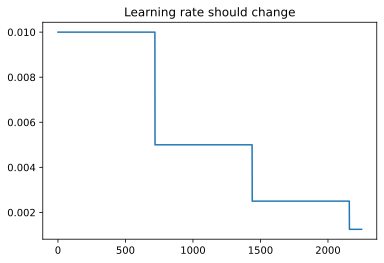

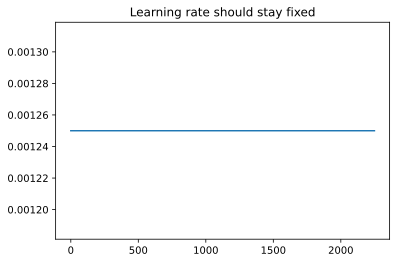

In [10]:
trainAcc,testAcc,losses,net,currentLR = function2trainTheModel(.01,True)
plt.plot(currentLR)
plt.title('Learning rate should change')
plt.show()

trainAcc,testAcc,losses,net,currentLR = function2trainTheModel(.01,False)
plt.plot(currentLR)
plt.title('Learning rate should stay fixed')
plt.show()